Autores: Natalia Echeverry Salcedo y Sergio Barreto

Fecha de Inicio: 03/08/2025

Fecha actual: 08/08/2025
## **Primer parcial Procesamietno de Datos**

## **Problemática**
 Una compañía esta de fútbol esta en busca de un nuevo equipo, pero para esto necesita analizar tanto los jugadores ( de la liga 17-18) como los equipos para asegurarse que se esta realizando una selección correcta.  

## **Objetivo**
Implementar modelos de predicción utilizando la biblioteca de aprendizaje automático MLlib PySpark, con el fin de explicar y analizar los datos, para de esta manera lograr una buena selección de jugadores.  

## **Metodología**
1) Cargar y perfilar datos (resultados, temporadas.json, jugadores).  
2) Seleccionar 6 variables clave por dataset y limpiar.  
3) Generar descriptivos y  visualizaciones.  
4) Hallazgos: equipos más fuertes por goles/victorias y posiciones/jugadores con mejor relación rendimiento–costo.  
5) Conclusiones y/o recomendaciones.


1. Importación de bibliotecas

In [1]:
#BIBLIOTECAS INICIALES
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
import matplotlib.pyplot as plt
import json
import os
import pandas as pd

ruta_json = "/json/temporadas.json"
#Bibliotecas especializadas
from pylab import *

In [2]:
#Bibliotecas de PySpark, mllib Y contexto para levantar la sesion de pyspark

#Busqueda e inicialización para pyspark
import findspark
findspark.init()

from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
import pyspark.sql.functions as F #Acceso a todas las funciones
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql import SparkSession

In [3]:
#Se crea una sesion para hacer el contexto de procesamiento desde mi Cuota del Cluster HPC
from pyspark import SparkConf
#Se levanta la configuracion
configura = SparkConf().set("spark.scheduler.mode", "FAIR")
configura.setAppName("HPC_ParcialNESB")

spark04 = SparkSession.builder.config(conf=configura).getOrCreate()
SQLContext(sparkContext=spark04.sparkContext, sparkSession=spark04)

contextoSpark04 = spark04.sparkContext.getOrCreate()

print("Sesión Cluster HPC: ParcialNESB 03/08/2025")
spark04

Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
25/09/08 18:21:19 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
25/09/08 18:21:19 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


Sesión Cluster HPC: ParcialNESB 03/08/2025


2. Carga de datos desde el IDRIVE

In [4]:
#Como se esta desde un servidor que no es mio, y ni siquiera lo he implementado, requiero saber que configuracion de HW me han dado a mi cuenta de sesion
#Adicional como cientifico que soy, tambien como hacer un cluster par asaber todo eso de implementacion de cluster
cantCPUS =spark04._jsc.sc().getExecutorMemoryStatus().keySet().size()
print(f"Cantidad de CPU's en mi sesion: {cantCPUS}")
print (spark04.sparkContext.getConf().getAll())

Cantidad de CPU's en mi sesion: 3
[('spark.app.submitTime', '1757373678960'), ('spark.dynamicAllocation.minExecutors', '1'), ('spark.ui.view.acls', '*'), ('spark.dynamicAllocation.initialExecutors', '2'), ('spark.eventLog.enabled', 'true'), ('spark.kryoserializer.buffer.max', '512m'), ('spark.memory.fraction', '0.7'), ('spark.history.fs.logDirectory', '/mnt/sda1/Cluster/Spark/histLog'), ('spark.dynamicAllocation.schedulerBacklogTimeout', '1s'), ('spark.executor.cores', '4'), ('spark.cores.max', '36'), ('spark.serializer', 'org.apache.spark.serializer.KryoSerializer'), ('spark.scheduler.allocation.file', '/mnt/sda1/Cluster/Spark/conf/fairscheduler.xml'), ('spark.io.compression.codec', 'lz4'), ('spark.driver.port', '20371'), ('spark.executor.instances', '2'), ('spark.network.timeout', '400s'), ('spark.executor.memory', '10G'), ('spark.serializer.objectStreamReset', '100'), ('spark.dynamicAllocation.maxExecutors', '6'), ('spark.dynamicAllocation.executorIdleTimeout', '60s'), ('spark.submi

In [5]:
!$HADOOP_HOME/bin/hadoop fs -ls /

Found 4 items
drwxr-xr-x   - sistemas  supergroup          0 2025-09-02 13:22 /csv
drwxr-xr-x   - sistemas  supergroup          0 2025-09-02 13:23 /json
drwxr-xr-x   - sistemas  supergroup          0 2025-09-02 16:56 /parquet
drwxrwxr-x+  - userpm025 supergroup          0 2025-09-01 12:48 /pm25


In [6]:
!$HADOOP_HOME/bin/hadoop fs -ls /csv

Found 7 items
-rw-r--r--   2 sistemas supergroup      40868 2025-07-07 15:41 /csv/Fortune500USCompanies.csv
-rw-r--r--   2 sistemas supergroup      34635 2025-09-02 13:22 /csv/jugadores.csv
-rw-r--r--   2 sistemas supergroup 1648942196 2025-06-20 12:32 /csv/metadata.csv
-rw-r--r--   2 sistemas supergroup    1082023 2025-09-02 13:22 /csv/resultados_futbol.csv
-rw-r--r--   2 sistemas supergroup     316971 2025-06-10 09:11 /csv/stroke_pyspark.csv
drwxr-xr-x   - sistemas supergroup          0 2025-06-18 15:36 /csv/taxi
-rw-r--r--   2 sistemas supergroup      48036 2025-06-12 14:31 /csv/waterquality.csv


In [7]:
#Se carga el CSV de Jugadores como OBJETO DATAFRAME Pyspark 

df00 = spark04.read.format("csv").option("header","true").load("hdfs://10.195.34.34:9000/csv/jugadores.csv")

#se requiere observar los primeros 20 datos cabecera
df00.show(20)

+--------------------+-------+---+--------+------------+------------+----------+---------+-------+----------+------+--------------+-----------+-------+-------+--------+-----------+
|                name|   club|age|position|position_cat|market_value|page_views|fpl_value|fpl_sel|fpl_points|region|   nationality|new_foreign|age_cat|club_id|big_club|new_signing|
+--------------------+-------+---+--------+------------+------------+----------+---------+-------+----------+------+--------------+-----------+-------+-------+--------+-----------+
|      Alexis Sanchez|Arsenal| 28|      LW|           1|          65|      4329|       12| 17.10%|       264|     3|         Chile|          0|      4|      1|       1|          0|
|          Mesut Ozil|Arsenal| 28|      AM|           1|          50|      4395|      9.5|  5.60%|       167|     2|       Germany|          0|      4|      1|       1|          0|
|           Petr Cech|Arsenal| 35|      GK|           4|           7|      1529|      5.5|  5.9

In [8]:
#Se carga el CSV de Resultados futbol como OBJETO DATAFRAME Pyspark 
df01 = spark04.read.format("csv").option("header","true").load("hdfs://10.195.34.34:9000/csv/resultados_futbol.csv")

#se requiere observar los primeros 20 datos cabecera
df01.show(20)

+-------+--------------------+----------------+----------------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
| Season|            DateTime|        HomeTeam|        AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|Referee| HS| AS|HST|AST| HC| AC| HF| AF| HY| AY| HR| AR|
+-------+--------------------+----------------+----------------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|1993-94|1993-08-14T00:00:00Z|         Arsenal|        Coventry|   0|   3|  A|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14T00:00:00Z|     Aston Villa|             QPR|   4|   1|  H|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14T00:00:00Z|         Chelsea|       Blackburn|   1|   2|  A|  NA|  NA| NA|     NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA| NA|
|1993-94|1993-08-14T00:00:00Z|       Liverpool|  Sheffield Weds|   2|   0|  H|  NA|  NA| NA|     NA| NA| N

3. Análisis y Preparación de Datos

Se presentan datos en formato CSV con los diferentes parámetros de los jugadores y los resultados de los partidos. 

-Tipo de datos: coherencia de tipo de datos, transformación.

-Columnas: conocimiento de las columnas, eliminación.

-Analisis de datos nulos o imposibles: conocimiento

In [9]:
#Conocimiento de las columnas de jugadores
df00.columns

['name',
 'club',
 'age',
 'position',
 'position_cat',
 'market_value',
 'page_views',
 'fpl_value',
 'fpl_sel',
 'fpl_points',
 'region',
 'nationality',
 'new_foreign',
 'age_cat',
 'club_id',
 'big_club',
 'new_signing']

In [10]:
#Conocimiento de las columnas de los resultados de los partidos
df01.columns

['Season',
 'DateTime',
 'HomeTeam',
 'AwayTeam',
 'FTHG',
 'FTAG',
 'FTR',
 'HTHG',
 'HTAG',
 'HTR',
 'Referee',
 'HS',
 'AS',
 'HST',
 'AST',
 'HC',
 'AC',
 'HF',
 'AF',
 'HY',
 'AY',
 'HR',
 'AR']

**Se presentan las estadísticas de datos a continuación:**

In [11]:
#Jugadores
for valor in df00.columns:
  df00.describe([valor]).show()

+-------+------------------+
|summary|              name|
+-------+------------------+
|  count|               461|
|   mean|              NULL|
| stddev|              NULL|
|    min|   Aaron Cresswell|
|    max|Åukasz FabiaÅ„ski|
+-------+------------------+

+-------+--------+
|summary|    club|
+-------+--------+
|  count|     461|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|West+Ham|
+-------+--------+

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|               461|
|   mean| 26.80477223427332|
| stddev|3.9618917037096124|
|    min|                17|
|    max|                38|
+-------+------------------+

+-------+--------+
|summary|position|
+-------+--------+
|  count|     461|
|   mean|    NULL|
| stddev|    NULL|
|    min|      AM|
|    max|      SS|
+-------+--------+

+-------+------------------+
|summary|      position_cat|
+-------+------------------+
|  count|               461|
|   mean| 2.1800

In [12]:
#Resultados de los partidos
for valor in df01.columns:
  df01.describe([valor]).show()

+-------+-------+
|summary| Season|
+-------+-------+
|  count|  11113|
|   mean|   NULL|
| stddev|   NULL|
|    min|1993-94|
|    max|2021-22|
+-------+-------+

+-------+--------------------+
|summary|            DateTime|
+-------+--------------------+
|  count|               11113|
|   mean|                NULL|
| stddev|                NULL|
|    min|1993-08-14T00:00:00Z|
|    max|2022-04-10T16:30:00Z|
+-------+--------------------+

+-------+--------+
|summary|HomeTeam|
+-------+--------+
|  count|   11113|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|  Wolves|
+-------+--------+

+-------+--------+
|summary|AwayTeam|
+-------+--------+
|  count|   11113|
|   mean|    NULL|
| stddev|    NULL|
|    min| Arsenal|
|    max|  Wolves|
+-------+--------+

+-------+------------------+
|summary|              FTHG|
+-------+------------------+
|  count|             11113|
|   mean| 1.518221902276613|
| stddev|1.3019811033373436|
|    min|                 0|
|    max| 

Visualización de los Datos

In [13]:
#Se crea una tabla de resumen de jugadores

df00.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df00.columns]).show()

+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|name|club|age|position|position_cat|market_value|page_views|fpl_value|fpl_sel|fpl_points|region|nationality|new_foreign|age_cat|club_id|big_club|new_signing|
+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|   0|   0|  0|       0|           0|           0|         0|        0|      0|         0|     0|          0|          0|      0|      0|       0|          0|
+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+



In [14]:
#Se crea una tabla de resumen de resultados futbol

df01.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df01.columns]).show()

+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|Season|DateTime|HomeTeam|AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|Referee| HS| AS|HST|AST| HC| AC| HF| AF| HY| AY| HR| AR|
+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|     0|       0|       0|       0|   0|   0|  0|   0|   0|  0|      0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+




*   Se observa que no hay datos nulos o imposibles
*   Se procede a graficar cada una de las dimensiones


**Proceso de creación de graficas**

Descripción general de los conjuntos de datos y sus variables más importantes
(a consideración de ustedes seleccionar 6).

In [15]:
#Se crea una vista para ser usada en las visualizaciones de jugadores

df00.createOrReplaceTempView("df00_sql")

In [16]:
df02 = spark04.sql('''Select * from df00_sql where 
            name is not null and
            position is not null and
            market_value is not null and
            fpl_points is not null and
            age is not null and
            club is not null''')

In [17]:
#Se verifica la Cantidad de Valores Nulos o Imposibles

df02.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df02.columns]).show()

+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|name|club|age|position|position_cat|market_value|page_views|fpl_value|fpl_sel|fpl_points|region|nationality|new_foreign|age_cat|club_id|big_club|new_signing|
+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+
|   0|   0|  0|       0|           0|           0|         0|        0|      0|         0|     0|          0|          0|      0|      0|       0|          0|
+----+----+---+--------+------------+------------+----------+---------+-------+----------+------+-----------+-----------+-------+-------+--------+-----------+



In [18]:
#Se crea una vista para ser usada en las visualizaciones de resultados futbol

df01.createOrReplaceTempView("df01_sql")

In [19]:
df03 = spark04.sql('''Select * from df01_sql where 
            HomeTeam is not null and
            AwayTeam is not null and
            Season is not null and
            DateTime is not null and
            FTHG is not null and
            FTAG is not null''')

In [20]:
#Se verifica la Cantidad de Valores Nulos o Imposibles

df03.select([F.count(F.when(F.isnan(c) | F.col(c).isNull(), c)).alias(c) for c in df03.columns]).show()

+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|Season|DateTime|HomeTeam|AwayTeam|FTHG|FTAG|FTR|HTHG|HTAG|HTR|Referee| HS| AS|HST|AST| HC| AC| HF| AF| HY| AY| HR| AR|
+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+
|     0|       0|       0|       0|   0|   0|  0|   0|   0|  0|      0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|  0|
+------+--------+--------+--------+----+----+---+----+----+---+-------+---+---+---+---+---+---+---+---+---+---+---+---+



**Tratamiento de datos**

**Variables seleccionadas: Jugadores**  

**Name (Nombre del jugador)**  
- **Significado:** Identificación del jugador en el dataset.  
- **Razón de selección:** Es indispensable para relacionar el rendimiento con individuos específicos.  

**Position (Posición en el campo)**  
- **Significado:** Rol táctico del jugador (defensa, mediocampo, delantero, etc.).  
- **Razón de selección:** Permite analizar cómo varía el rendimiento y el valor de mercado según el rol dentro del equipo.  

**Market_value (Valor de mercado)**  
- **Significado:** Estimación económica del costo de fichaje del jugador.  
- **Razón de selección:** Variable clave para evaluar la relación entre rendimiento deportivo y valor económico.  

**FPL_points (Puntos Fantasy Premier League)**  
- **Significado:** Puntuación otorgada a cada jugador en función de su rendimiento en la temporada.  
- **Razón de selección:** Sirve como indicador cuantitativo del desempeño individual de cada jugador.  

**Age (Edad)**  
- **Significado:** Edad actual del jugador.  
- **Razón de selección:** Es relevante para analizar etapas de carrera, potencial de crecimiento y relación entre edad, rendimiento y valor de mercado.  

**Club (Equipo al que pertenece)**  
- **Significado:** Nombre del club en el que juega el jugador.  
- **Razón de selección:** Permite vincular el rendimiento individual con el desempeño colectivo del club, además de facilitar comparaciones entre equipos.  

In [21]:
#Jugadores
df02.dtypes

[('name', 'string'),
 ('club', 'string'),
 ('age', 'string'),
 ('position', 'string'),
 ('position_cat', 'string'),
 ('market_value', 'string'),
 ('page_views', 'string'),
 ('fpl_value', 'string'),
 ('fpl_sel', 'string'),
 ('fpl_points', 'string'),
 ('region', 'string'),
 ('nationality', 'string'),
 ('new_foreign', 'string'),
 ('age_cat', 'string'),
 ('club_id', 'string'),
 ('big_club', 'string'),
 ('new_signing', 'string')]

In [22]:
# Nos quedamos solo con las 6 columnas
df02 = df02.select("name", "position", "market_value", "fpl_points", "age", "club")

In [23]:
# Cambiamos tipos de datos
df02 = (df02
    .withColumn("market_value", F.col("market_value").cast(DoubleType()))
    .withColumn("fpl_points",   F.col("fpl_points").cast(DoubleType()))
    .withColumn("age",          F.col("age").cast(IntegerType()))
    .withColumn("position",     F.col("position").cast(StringType()))
    .withColumn("club",         F.col("club").cast(StringType()))
)

In [24]:
# Revisar los tipos de datos resultantes
df02.dtypes

[('name', 'string'),
 ('position', 'string'),
 ('market_value', 'double'),
 ('fpl_points', 'double'),
 ('age', 'int'),
 ('club', 'string')]

**Variables seleccionadas: Resultados de Fútbol**  

**HomeTeam (Equipo local)**  
- **Significado:** Nombre del equipo que juega como local en cada partido.  
- **Razón de selección:** Permite analizar el desempeño de los equipos en condición de local, identificando ventajas y tendencias.  

**AwayTeam (Equipo visitante)**  
- **Significado:** Nombre del equipo que juega como visitante en cada partido.  
- **Razón de selección:** Complementa la variable anterior para comparar el rendimiento entre jugar en casa o fuera de ella.  

**Season (Temporada)**  
- **Significado:** Año o rango de años en que se disputa la liga.  
- **Razón de selección:** Permite realizar análisis temporales y detectar cambios en el rendimiento de los equipos a lo largo de diferentes temporadas.  

**DateTime (Fecha y hora del partido)**  
- **Significado:** Momento exacto en que se llevó a cabo el partido.  
- **Razón de selección:** Facilita ordenar cronológicamente los datos y relacionarlos con factores externos (por ejemplo, etapas de la liga).  

**FTHG (Full Time Home Goals)**  
- **Significado:** Número de goles anotados por el equipo local al final del partido.  
- **Razón de selección:** Es un indicador clave del desempeño ofensivo de los locales y un insumo fundamental para el resultado del encuentro.  

**FTAG (Full Time Away Goals)**  
- **Significado:** Número de goles anotados por el equipo visitante al final del partido.  
- **Razón de selección:** Complementa a FTHG y permite construir el resultado final del partido, así como calcular diferencias de goles.  

---


In [25]:
#Resultados futbol
df03.dtypes

[('Season', 'string'),
 ('DateTime', 'string'),
 ('HomeTeam', 'string'),
 ('AwayTeam', 'string'),
 ('FTHG', 'string'),
 ('FTAG', 'string'),
 ('FTR', 'string'),
 ('HTHG', 'string'),
 ('HTAG', 'string'),
 ('HTR', 'string'),
 ('Referee', 'string'),
 ('HS', 'string'),
 ('AS', 'string'),
 ('HST', 'string'),
 ('AST', 'string'),
 ('HC', 'string'),
 ('AC', 'string'),
 ('HF', 'string'),
 ('AF', 'string'),
 ('HY', 'string'),
 ('AY', 'string'),
 ('HR', 'string'),
 ('AR', 'string')]

In [26]:
# Nos quedamos solo con las 6 columnas
df03 = df03.select("HomeTeam", "AwayTeam", "Season", "DateTime", "FTHG", "FTAG")

In [27]:
# Cambiamos tipos de datos
df03 = df03.withColumn("HomeTeam", df03["HomeTeam"].cast(StringType())) \
           .withColumn("AwayTeam", df03["AwayTeam"].cast(StringType())) \
           .withColumn("Season", df03["Season"].cast(StringType())) \
           .withColumn("DateTime", df03["DateTime"].cast(StringType())) \
           .withColumn("FTHG", df03["FTHG"].cast(IntegerType())) \
           .withColumn("FTAG", df03["FTAG"].cast(IntegerType()))

In [28]:
# Revisar los tipos de datos resultantes
df03.dtypes

[('HomeTeam', 'string'),
 ('AwayTeam', 'string'),
 ('Season', 'string'),
 ('DateTime', 'string'),
 ('FTHG', 'int'),
 ('FTAG', 'int')]

**Creación de Tablas para Visualizar los datos para jugadores**


*   Se hace uso de la función LAMBDA para hacer el tratamiento y limpieza de los datos




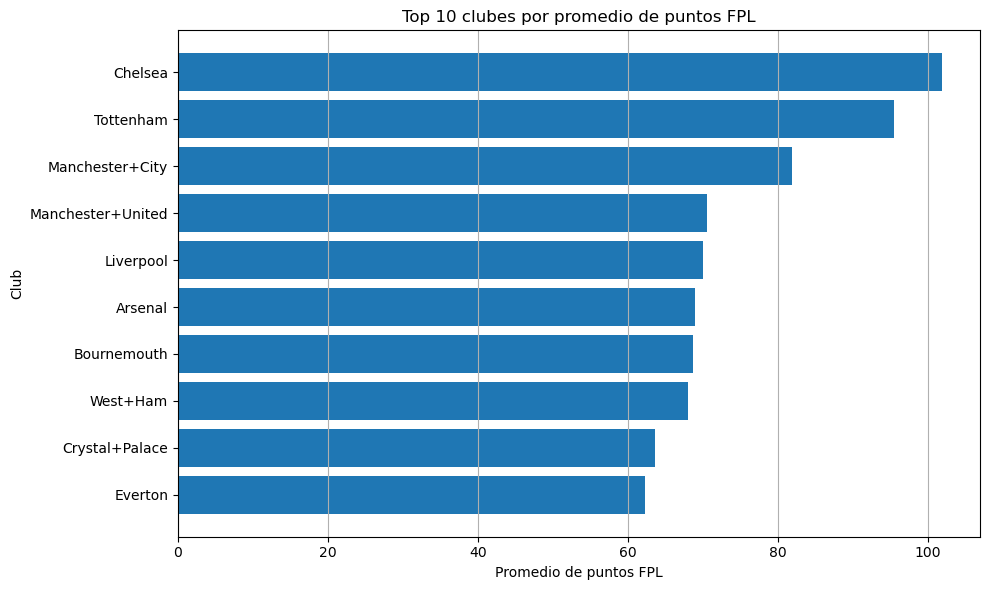

In [29]:
# Promedio de puntos por club (orden descendente)
top_clubs_pdf = (df02
    .groupBy("club")
    .agg(F.avg("fpl_points").alias("avg_fpl_points"), F.count("*").alias("n_players"))
    .filter(F.col("n_players") >= 20) 
    .orderBy(F.desc("avg_fpl_points"))
    .limit(10)
    .toPandas()
)

# Ordenar para que el barh salga de mayor a menor
top_clubs_pdf = top_clubs_pdf.sort_values("avg_fpl_points", ascending=True)

plt.figure(figsize=(10,6))
plt.barh(top_clubs_pdf["club"], top_clubs_pdf["avg_fpl_points"])
plt.title("Top 10 clubes por promedio de puntos FPL")
plt.xlabel("Promedio de puntos FPL")
plt.ylabel("Club")
plt.grid(axis='x')
plt.tight_layout()
plt.show()


**Análisis de resultados**  

- **Chelsea** lidera el ranking con el mayor promedio de puntos FPL, superando incluso a equipos reconocidos como Tottenham, Manchester City y Manchester United.  
- **Tottenham y Manchester City** ocupan el segundo y tercer lugar respectivamente, mostrando también un buen nivel de consistencia en la contribución de sus jugadores.  
- En el rango medio aparecen clubes de élite como **Liverpool y Arsenal**, que aunque competitivos, no alcanzaron los promedios más altos en ese periodo.  
- Llama la atención que equipos con menor tradición como **Bournemouth, West Ham, Crystal Palace y Everton** también aparecen en el Top 10. Esto indica que, aunque no sean candidatos al título, sus jugadores tuvieron un desempeño destacable en FPL.  

**Conclusión**  
La gráfica demuestra que no solo los clubes “grandes” concentran jugadores de alto rendimiento, sino que también hay oportunidades interesantes en equipos de media tabla. Para un nuevo club que busca fichajes estratégicos, conviene observar tanto a los líderes (para buscar referentes) como a clubes medianos, donde podría haber **jugadores con alta relación costo-beneficio**.  

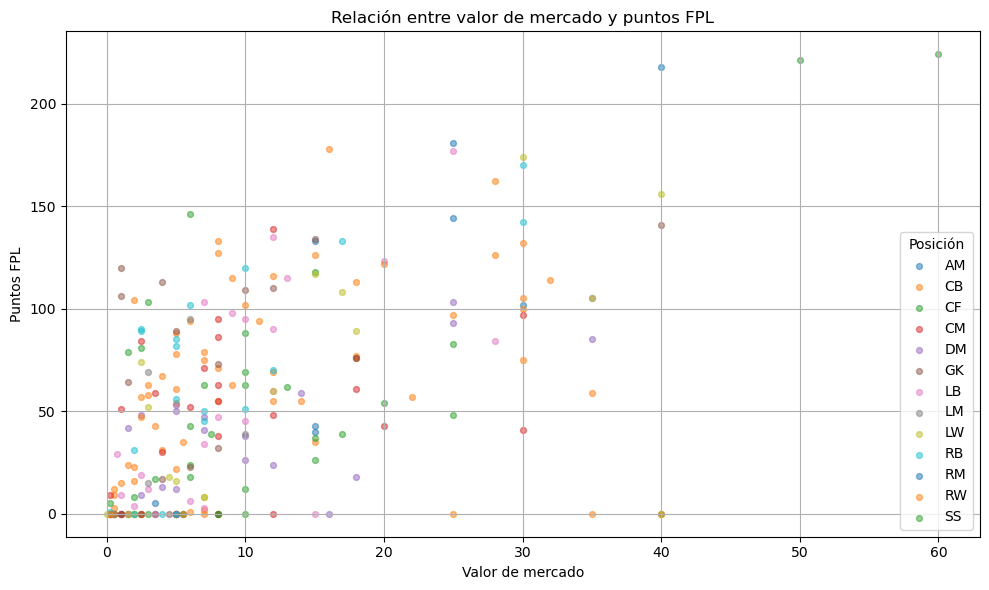

In [30]:
# Muestreamos para que la nube sea legible si hay muchos jugadores
pdf_scatter = (df02
               .select("market_value", "fpl_points", "position")
               .dropna()
               .sample(False, 0.5, seed=42)  # 50% de muestra aleatoria; ajusta si quieres
               .toPandas())

plt.figure(figsize=(10,6))

# Graficar cada posición en un color distinto
for pos, sub in pdf_scatter.groupby("position"):
    plt.scatter(sub["market_value"], sub["fpl_points"], 
                s=18, alpha=0.5, label=pos)

# Títulos y etiquetas
plt.title("Relación entre valor de mercado y puntos FPL")
plt.xlabel("Valor de mercado")
plt.ylabel("Puntos FPL")
plt.grid(True)
plt.legend(title="Posición")
plt.tight_layout()
plt.show()


**Análisis de resultados**  

La gráfica muestra que la mayoría de los jugadores se concentran en un **valor de mercado bajo (entre 0 y 10 millones)**, con puntuaciones FPL que varían desde muy bajas hasta alrededor de 100 puntos. A medida que el valor de mercado aumenta, se observan jugadores que alcanzan puntuaciones FPL más altas, aunque la relación no es perfectamente lineal.  

Se identifican algunos **outliers**, es decir, jugadores con valores de mercado muy elevados (superiores a 40 millones) que logran acumular más de 200 puntos FPL, lo que indica su rol determinante dentro de la liga. Sin embargo, también existen casos de jugadores caros con puntuaciones mucho más discretas, lo cual refleja que el alto costo no siempre garantiza un alto rendimiento.  

El uso de colores por posición permite ver diferencias interesantes: algunas posiciones concentran más jugadores en los rangos bajos de valor y puntos, mientras que otras presentan individuos que destacan tanto en valor económico como en desempeño.  

**Conclusiones**  

- Existe una **tendencia general positiva**: los jugadores con mayor valor de mercado tienden a obtener más puntos FPL, aunque con excepciones notables.  
- El **segmento más numeroso** corresponde a jugadores de bajo costo y rendimiento medio, que representan la base de la liga.  
- Se destacan algunos jugadores como **referentes de alto valor y alto rendimiento**, claves para cualquier estrategia de fichajes.  
- Para un nuevo club, resulta estratégico considerar tanto a las **figuras consolidadas** (aunque costosas) como a los jugadores de **alta eficiencia costo-beneficio** que, con bajo valor, han demostrado un rendimiento sobresaliente.  


/tmp/ipykernel_140019/967566830.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(data, labels=order, showmeans=True)


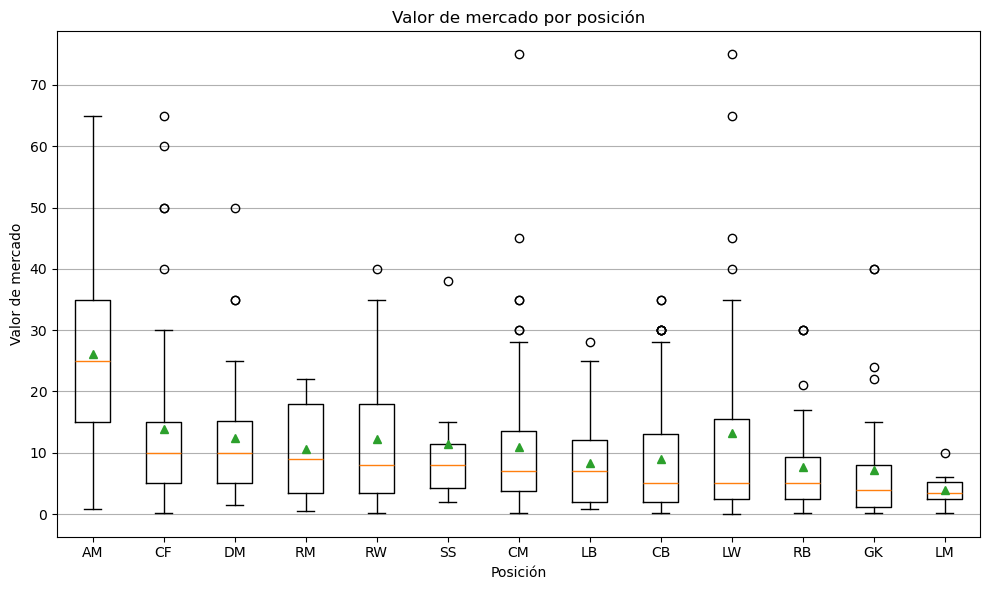

In [31]:

pos_pdf = (df02
           .select("position", "market_value")
           .dropna()
           .toPandas())

# Ordenar posiciones por mediana de valor de mercado (más informativo)
order = (pos_pdf.groupby("position")["market_value"]
         .median()
         .sort_values(ascending=False)
         .index
         .tolist())

# Crear una lista de arrays, cada uno con los valores de mercado de una posición
data = [pos_pdf.loc[pos_pdf["position"]==p, "market_value"].values for p in order]

# Gráfica tipo boxplot
plt.figure(figsize=(10,6))
plt.boxplot(data, labels=order, showmeans=True)

# Personalización
plt.title("Valor de mercado por posición")
plt.xlabel("Posición")
plt.ylabel("Valor de mercado")
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**Análisis de resultados**  

La gráfica muestra la distribución del **valor de mercado de los jugadores según su posición en el campo**. Se observan diferencias notables:  

- Los **mediapuntas (AM)** presentan los valores de mercado más altos, con medianas y promedios significativamente superiores al resto de posiciones.  
- En contraste, posiciones como **laterales izquierdos (LB), laterales derechos (RB), porteros (GK) y mediocampistas defensivos (DM)** tienen valores de mercado considerablemente más bajos.  
- Existen **outliers** en casi todas las posiciones, representados por jugadores excepcionales que alcanzan valores de mercado muy por encima de la media (por ejemplo, mediapuntas, extremos y delanteros centros).  
- La dispersión de valores es mucho mayor en las posiciones ofensivas, mientras que en las defensivas los valores tienden a ser más homogéneos y concentrados en rangos bajos.  

**Conclusiones**  

- El mercado **valora más a los jugadores ofensivos**, especialmente a los mediapuntas, reflejando su impacto directo en la generación de goles y jugadas de ataque.  
- Los **jugadores defensivos y porteros** suelen tener menor valoración económica, lo cual sugiere que, aunque son fundamentales, no son tan determinantes en el mercado como los atacantes.  
- La presencia de **outliers en todas las posiciones** indica que, independientemente del rol, siempre existen jugadores que destacan y alcanzan un valor de mercado superior.  
- Para un nuevo club, esta información es clave para **definir la estrategia de fichajes**: invertir más en jugadores ofensivos de alto impacto y buscar oportunidades de **eficiencia costo-beneficio en posiciones defensivas**.  


**Creación de Tablas para Visualizar los datos para resultados futbol**


*   Se hace uso de la función LAMBDA para hacer el tratamiento y limpieza de los datos




In [32]:
# Crear la vista temporal
df03.createOrReplaceTempView("df03_sql")

# HomeTeam
HomeTeam_parametro = spark04.sql("SELECT HomeTeam FROM df03_sql")
HomeTeam_parametro = HomeTeam_parametro.rdd.map(lambda fila: fila.HomeTeam).collect()

# AwayTeam
AwayTeam_parametro = spark04.sql("SELECT AwayTeam FROM df03_sql")
AwayTeam_parametro = AwayTeam_parametro.rdd.map(lambda fila: fila.AwayTeam).collect()

# Season
Season_parametro = spark04.sql("SELECT Season FROM df03_sql")
Season_parametro = Season_parametro.rdd.map(lambda fila: fila.Season).collect()

# DateTime
DateTime_parametro = spark04.sql("SELECT DateTime FROM df03_sql")
DateTime_parametro = DateTime_parametro.rdd.map(lambda fila: fila.DateTime).collect()

# FTHG (Full Time Home Goals)
FTHG_parametro = spark04.sql("SELECT FTHG FROM df03_sql")
FTHG_parametro = FTHG_parametro.rdd.map(lambda fila: fila.FTHG).collect()

# FTAG (Full Time Away Goals)
FTAG_parametro = spark04.sql("SELECT FTAG FROM df03_sql")
FTAG_parametro = FTAG_parametro.rdd.map(lambda fila: fila.FTAG).collect()


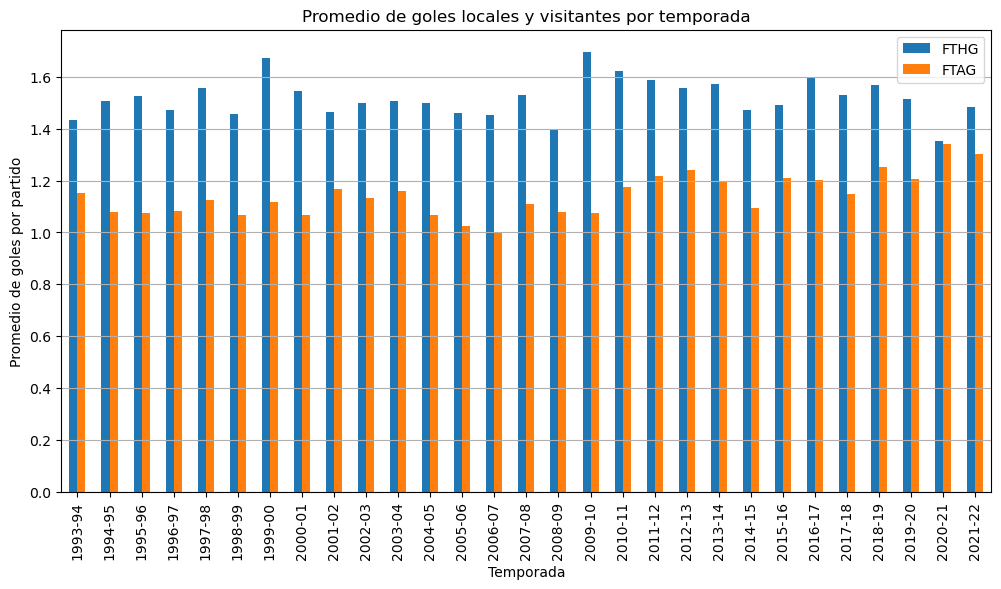

In [33]:
# Crear un DataFrame auxiliar con las listas
df_goles = pd.DataFrame({
    "Season": Season_parametro,  # Temporada
    "FTHG": FTHG_parametro,      # Goles local
    "FTAG": FTAG_parametro       # Goles visitante
})

# Calcular el promedio de goles por temporada
promedios = df_goles.groupby("Season").mean()

# Graficar los promedios
promedios.plot(kind="bar", figsize=(12,6))

# Títulos y etiquetas
plt.title("Promedio de goles locales y visitantes por temporada")
plt.ylabel("Promedio de goles por partido")
plt.xlabel("Temporada")
plt.grid(axis='y')
plt.show()

**Análisis de resultados**  

La gráfica muestra el **promedio de goles anotados por equipos locales (FTHG) y visitantes (FTAG) en cada temporada de la Premier League** desde 1993-94 hasta 2021-22.  

- A lo largo de todas las temporadas, los **equipos locales mantienen consistentemente un promedio de goles superior** al de los visitantes, confirmando la ventaja estadística de jugar en casa.  
- El promedio de goles de los locales se mantiene en un rango de **1.4 a 1.6 goles por partido**, mientras que los visitantes suelen oscilar entre **1.0 y 1.2 goles por partido**.  
- Se observan picos en algunas temporadas, como 2001-02 y 2009-10, donde los equipos locales superaron 1.6 goles de promedio.  
- Aunque los visitantes también muestran ligeros incrementos en temporadas recientes, la brecha entre locales y visitantes se mantiene constante a lo largo de los años.  

**Conclusiones**  

- El análisis confirma la existencia de una **ventaja de localía**, ya que los equipos en casa tienden a marcar más goles en promedio que los visitantes.  
- La diferencia entre goles locales y visitantes se mantiene relativamente **estable en el tiempo**, lo que refleja un patrón consolidado en la liga.  
- Para un nuevo club, estos datos son relevantes porque sugieren que **maximizar el rendimiento como local** puede ser clave para obtener buenos resultados en la liga.  
- Aunque la tendencia muestra un aumento ligero en la producción ofensiva de los visitantes en temporadas recientes, el **factor casa sigue siendo determinante** en la Premier League.  


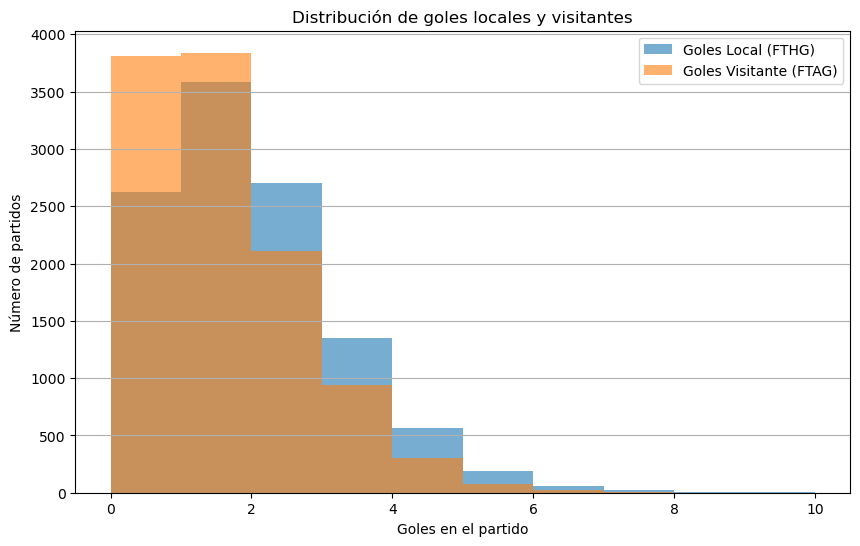

In [34]:
import matplotlib.pyplot as plt

#Histograma de distribución de goles
max_goles = max(max(FTHG_parametro), max(FTAG_parametro))  
bins = range(0, int(max_goles) + 2)  

plt.figure(figsize=(10,6))
plt.hist(FTHG_parametro, bins=bins, alpha=0.6, label="Goles Local (FTHG)")
plt.hist(FTAG_parametro, bins=bins, alpha=0.6, label="Goles Visitante (FTAG)")

plt.title("Distribución de goles locales y visitantes")
plt.xlabel("Goles en el partido")
plt.ylabel("Número de partidos")
plt.legend()
plt.grid(axis='y')
plt.show()


**Análisis de resultados**  

La gráfica muestra la **distribución de goles anotados por equipos locales (FTHG) y visitantes (FTAG)** en los partidos de la Premier League.  

- La mayoría de los encuentros terminan con **pocos goles**, siendo más frecuentes los resultados de **0, 1 o 2 goles** por equipo.  
- Los equipos locales presentan una **mayor proporción de partidos con 2 o más goles** en comparación con los visitantes.  
- A medida que aumenta el número de goles, la frecuencia de partidos disminuye drásticamente, lo cual refleja que los marcadores abultados son menos comunes.  
- Existen pocos casos en los que un equipo llega a marcar más de **5 goles**, lo que los convierte en eventos atípicos dentro de la distribución.  

**Conclusiones**  

- El fútbol en la Premier League tiende a ser de **marcadores moderados**, donde la mayoría de los equipos anota entre 0 y 2 goles por partido.  
- Los equipos locales tienen una **ligera ventaja ofensiva**, pues muestran una mayor frecuencia de partidos con más de 2 goles respecto a los visitantes.  
- Los resultados de goleadas son **poco frecuentes**, lo que indica un nivel de competitividad relativamente equilibrado entre los equipos.  
- Para un nuevo club, esta información es útil porque sugiere que **construir una defensa sólida y un ataque consistente capaz de marcar al menos 2 goles por partido** puede ser suficiente para competir de manera efectiva en la liga.  


/tmp/ipykernel_140019/379764940.py:5: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([FTHG_parametro, FTAG_parametro], labels=["Local", "Visitante"], showmeans=True)


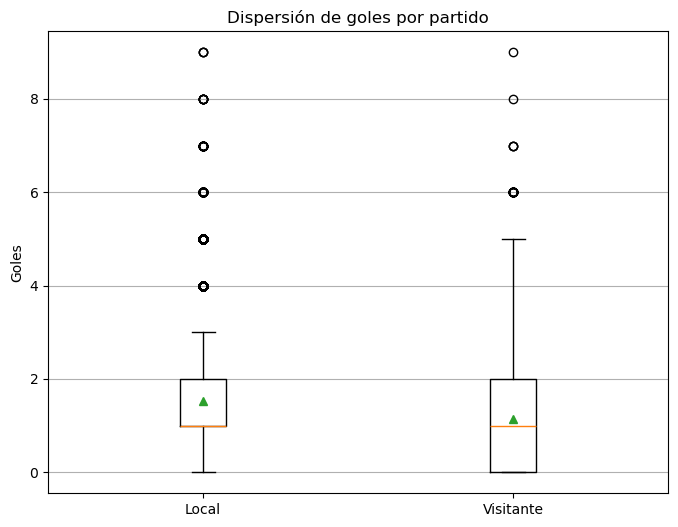

In [35]:
import matplotlib.pyplot as plt

# Boxplot de goles (local vs visitante) 
plt.figure(figsize=(8,6))
plt.boxplot([FTHG_parametro, FTAG_parametro], labels=["Local", "Visitante"], showmeans=True)

plt.title("Dispersión de goles por partido")
plt.ylabel("Goles")
plt.grid(axis='y')
plt.show()


**Análisis de resultados**  

La gráfica muestra la **dispersión de goles por partido** diferenciando entre equipos locales y visitantes.  

- Los equipos locales presentan una **mediana cercana a 1 gol por partido**, con la mayoría de los valores concentrados entre 1 y 2 goles.  
- Los visitantes también muestran una mediana alrededor de 1 gol, pero con una distribución ligeramente más dispersa hacia valores bajos (0 goles).  
- Se observan **outliers** en ambos casos, es decir, partidos con marcadores atípicos donde un equipo logra anotar 6, 7, 8 o hasta 9 goles.  
- La dispersión es mayor en los equipos visitantes, reflejando mayor variabilidad en su desempeño ofensivo.  

**Conclusiones**  

- Tanto locales como visitantes suelen anotar en promedio **entre 1 y 2 goles por partido**, lo que confirma que los marcadores altos son poco frecuentes.  
- Los equipos locales tienden a mostrar una **mayor consistencia**, mientras que los visitantes presentan más variación en su producción ofensiva.  
- La presencia de outliers indica que, aunque son raros, los partidos con goleadas extremas ocurren en ambas condiciones.  
- Para un nuevo club, esta información sugiere que **mantener una ofensiva estable que asegure al menos 1 o 2 goles por partido** puede ser suficiente para competir en la mayoría de los encuentros.  


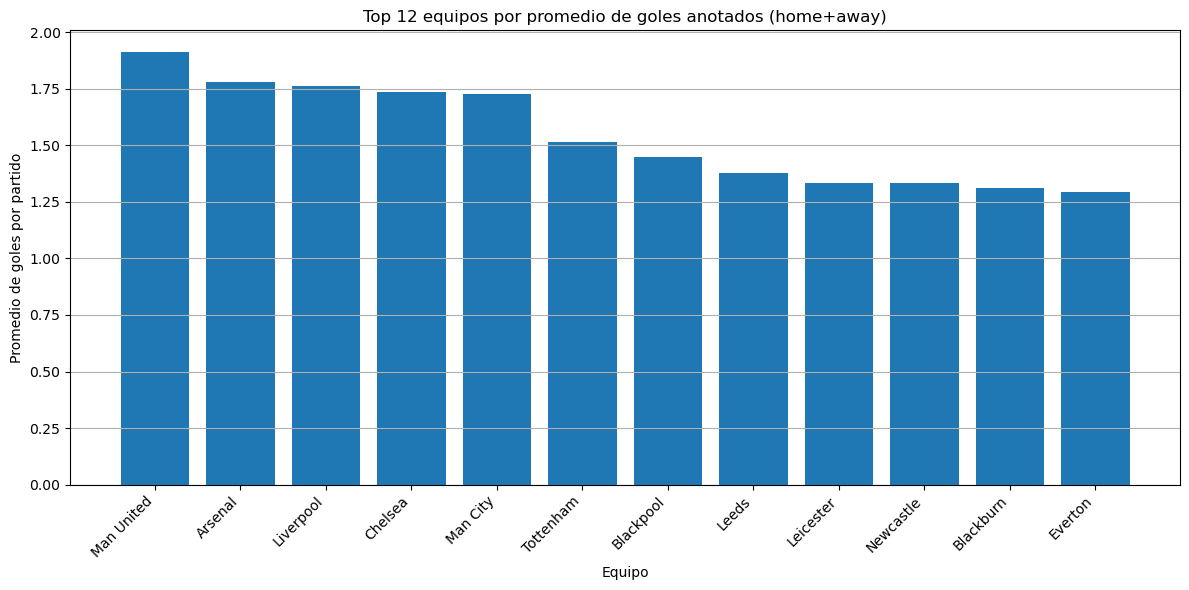

In [36]:
import matplotlib.pyplot as plt
from pyspark.sql import functions as F

# Promedio de goles por equipo (local y visitante) 
# Promedio goles cuando el equipo juega en casa
team_home = (
    df03.groupBy("HomeTeam")
        .agg(F.avg("FTHG").alias("avg_home_goals"))
        .withColumnRenamed("HomeTeam", "Team")
)

# Promedio goles cuando el equipo juega de visitante
team_away = (
    df03.groupBy("AwayTeam")
        .agg(F.avg("FTAG").alias("avg_away_goals"))
        .withColumnRenamed("AwayTeam", "Team")
)

# Unimos y calculamos un promedio total simple (home/away)
team_avg = (
    team_home.join(team_away, on="Team", how="outer")
             .fillna(0)  # por si algún equipo no aparece en uno de los dos contextos
             .withColumn("avg_total_goals", (F.col("avg_home_goals") + F.col("avg_away_goals"))/2)
)

# Top 12 equipos por promedio total de goles
top12_pdf = (
    team_avg.orderBy(F.desc("avg_total_goals"))
            .limit(12)
            .toPandas()
)

# Orden para que barras salgan de mayor a menor
top12_pdf = top12_pdf.sort_values("avg_total_goals", ascending=False)

# Gráfica de barras 
plt.figure(figsize=(12,6))
plt.bar(top12_pdf["Team"], top12_pdf["avg_total_goals"])

plt.title("Top 12 equipos por promedio de goles anotados (home+away)")
plt.xlabel("Equipo")
plt.ylabel("Promedio de goles por partido")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()


**Análisis de resultados**  

La gráfica presenta el **Top 12 de equipos con mayor promedio de goles anotados por partido**, considerando tanto partidos de local como de visitante.  

- **Manchester United** encabeza la lista con un promedio cercano a los 2 goles por partido, destacándose como el equipo más ofensivo.  
- Le siguen **Arsenal, Liverpool, Chelsea y Manchester City**, con promedios que rondan entre 1.7 y 1.8 goles por encuentro, lo que confirma su rol protagónico en la liga.  
- En posiciones intermedias aparecen equipos como **Tottenham y Blackpool**, con valores superiores a 1.5 goles en promedio.  
- Los equipos de la parte baja del ranking, como **Leeds, Leicester, Newcastle, Blackburn y Everton**, tienen promedios cercanos a 1.3 goles, lo cual sigue siendo competitivo, aunque menor que los líderes.  

**Conclusiones**  

- Los resultados confirman que los **equipos históricos de la Premier League** (Manchester United, Arsenal, Liverpool, Chelsea y Manchester City) mantienen una **clara superioridad ofensiva**.  
- El hecho de que clubes como **Blackpool o Leeds** aparezcan en el ranking evidencia que, en determinadas temporadas, estos equipos han logrado desempeños ofensivos destacados.  
- La diferencia entre el primer lugar (Manchester United) y los últimos del Top 12 es significativa, lo que refleja la **desigualdad ofensiva entre los clubes más poderosos y el resto**.  
- Para un nuevo club interesado en fichajes o en definir su estilo de juego, estos datos sugieren la importancia de **modelar su ofensiva tomando como referencia a los equipos líderes**, que logran mantener altos promedios de goles tanto en casa como de visita.  


Se tiene el interés de conocer un poco más los
equipos y resultados que se obtuvieron en la liga de 17-18, para así poder tener una
mejor idea de que tipos de jugadores se preferiría contratar y que estilo de juego
quiere que tenga su equipo.

**Elegir un club por jugador (el más frecuente)**

Vincular club con las seasons

In [37]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window as W

# Usamos solo las columnas de jugadores
df_players = (
    df00.select("name", "club", "fpl_points", "market_value")
        .dropna(subset=["name", "club", "fpl_points"])
)

# Si un jugador aparece repetido, promediamos 
agg_players = (
    df_players.groupBy("club", "name")
              .agg(
                  F.avg("fpl_points").alias("fpl_avg"),
                  F.avg("market_value").alias("mv_avg")
              )
)

# Ranking por club
w = W.partitionBy("club").orderBy(F.desc("fpl_avg"), F.desc("mv_avg"), F.asc("name"))

top10_por_club = (
    agg_players.withColumn("rank", F.row_number().over(w))
               .filter(F.col("rank") <= 10)
               .orderBy("club", "rank")
)

# Mostrar tablas separadas por club usando show()
clubs = [row["club"] for row in top10_por_club.select("club").distinct().collect()]

for c in clubs:
    print(f"\n===== {c} =====")
    top10_por_club.filter(F.col("club") == c).select("rank","name","fpl_avg","mv_avg").show(truncate=False)



===== Arsenal =====
+----+-----------------+-------+------+
|rank|name             |fpl_avg|mv_avg|
+----+-----------------+-------+------+
|1   |Alexis Sanchez   |264.0  |65.0  |
|2   |Mesut Ozil       |167.0  |50.0  |
|3   |Petr Cech        |134.0  |7.0   |
|4   |Theo Walcott     |122.0  |20.0  |
|5   |Laurent Koscielny|121.0  |22.0  |
|6   |Hector Bellerin  |119.0  |30.0  |
|7   |Olivier Giroud   |116.0  |22.0  |
|8   |Nacho Monreal    |115.0  |13.0  |
|9   |Shkodran Mustafi |90.0   |30.0  |
|10  |Alex Iwobi       |89.0   |10.0  |
+----+-----------------+-------+------+


===== Bournemouth =====
+----+----------------+-------+------+
|rank|name            |fpl_avg|mv_avg|
+----+----------------+-------+------+
|1   |Joshua King     |178.0  |8.0   |
|2   |Jermain Defoe   |166.0  |5.0   |
|3   |Charlie Daniels |134.0  |3.0   |
|4   |Artur Boruc     |120.0  |1.0   |
|5   |Steve Cook      |112.0  |5.0   |
|6   |Junior Stanislas|107.0  |4.5   |
|7   |Adam Smith      |104.0  |5.0   |
|8 

In [38]:
# Filtrar solo la temporada 2017-18
df_1718 = df01.filter(F.col("Season") == "2017-18")

# Determinar ganador por partido
df_winner = df_1718.withColumn(
    "Winner",
    F.when(F.col("FTR") == "H", F.col("HomeTeam"))
     .when(F.col("FTR") == "A", F.col("AwayTeam"))
     .otherwise(F.lit(None))  # empates quedan como null
)

# Contar victorias por club
wins_per_club = (
    df_winner.filter(F.col("Winner").isNotNull())
             .groupBy("Winner")
             .agg(F.count("*").alias("Wins"))
             .orderBy(F.desc("Wins"))
)

pdf_wins = wins_per_club.toPandas()

# Gráfica de barras
plt.figure(figsize=(12,6))
plt.bar(pdf_wins["Winner"], wins["Wins"], color="skyblue")
plt.title("Cantidad de partidos ganados por club - Season 2017-18")
plt.xlabel("Club")
plt.ylabel("Victorias")
plt.xticks(rotation=45, ha="right")
plt.grid(axis="y")
plt.tight_layout()
plt.show()


NameError: name 'wins' is not defined

<Figure size 1200x600 with 0 Axes>

**Conversion de JSON a CSV**

In [ ]:
!$HADOOP_HOME/bin/hadoop fs -ls /json
# Deberías ver /json/temporadas.json listado


In [ ]:
rdd = spark04.sparkContext.textFile("hdfs://10.195.34.34:9000/json/temporadas.json")
rdd.take(5)   # imprime 5 líneas para inspección


In [ ]:
from pyspark.sql.functions import from_json, col
from pyspark.sql.types import MapType, StringType, StructType

# 1) Leemos el archivo como texto
df_text = spark04.read.text("hdfs://10.195.34.34:9000/json/temporadas.json")

# 2) Unimos todas las líneas en un solo string (porque es un objeto multilínea)
json_str = "\n".join(df_text.select("value").rdd.flatMap(lambda x: x).collect())

# 3) Creamos un DataFrame pequeño con esa cadena completa
df_single = spark04.createDataFrame([(json_str,)], ["raw_json"])

# 4) Interpretamos como un Map de clave->valor (IDs dinámicos)
df_parsed = df_single.select(from_json(col("raw_json"), MapType(StringType(), StringType())).alias("data"))

df_parsed.show(truncate=False)
